In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as T
import torch.utils.data as td
import random
from dataset import XRayDataset
from torchvision.models import efficientnet_b0, alexnet
from torch.utils.data import DataLoader, SubsetRandomSampler
from helpers import obtain_predictions, train
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
import copy
%matplotlib inline

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

In [2]:
preprocess = T.Compose([
    T.Grayscale(3),                     # convert to grayscale
    T.RandomRotation(0.2),              # randomly rotate image within a range
    T.RandomHorizontalFlip(0.1),        # randomly perform a horizontal flip
    T.Resize((312, 312)),               # resize images to standard format
    T.CenterCrop(224),                  # crop to center to remove letters
    T.ToTensor(),                       # transform from PIL to tensor
    T.Normalize([0.485, 0.456, 0.406],  # normalize according to pytorch
                [0.229, 0.224, 0.225]), # guidelines for pre-trained models
])

no_augment = T.Compose([
    T.Grayscale(3),                     # convert to grayscale
    T.Resize((312, 312)),               # resize images to standard format
    T.CenterCrop(224),                  # crop to center to remove letters
    T.ToTensor(),                       # transform from PIL to tensor
    T.Normalize([0.485, 0.456, 0.406],  # normalize according to pytorch
                [0.229, 0.224, 0.225]), # guidelines for pre-trained models
])

In [3]:
# NOTE: This takes long! ~3 minutes :-)

# Create Datasets
train_dataset = XRayDataset('../data/train/', transform=preprocess)
valid_dataset = XRayDataset('../data/val/', transform=preprocess)

# Setup no-augmented version for cross validation
train_dataset_na = XRayDataset('../data/train/', transform=no_augment)
valid_dataset_na = XRayDataset('../data/val/', transform=no_augment)

# Setup the test set
test_dataset  = XRayDataset('../data/test/', transform=no_augment)

In [4]:
# Obtain the labels, which we will use later
train_labels = train_dataset.y
valid_labels = valid_dataset.y
train_labels = torch.concat([torch.tensor(train_labels), torch.tensor(valid_labels)])

# Concatenate the train and validation datasets
train_dataset = td.ConcatDataset((train_dataset, valid_dataset))
train_dataset_na = td.ConcatDataset((train_dataset_na, valid_dataset_na))

# Setup the test data loader
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Feature batch shape: torch.Size([64, 3, 224, 224])
Labels batch shape: torch.Size([64])


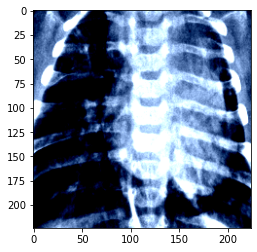

Label: 1


In [5]:
def display_image(tensor_image, label):
    tensor_image = np.swapaxes(tensor_image, 0, 2)
    tensor_image = np.swapaxes(tensor_image, 0, 1)
    plt.imshow(tensor_image)
    plt.show()
    print(f"Label: {label}")

# Display image and label.
features, labels = next(iter(test_dataloader))
print(f"Feature batch shape: {features.size()}")
print(f"Labels batch shape: {labels.size()}")

# Display an image
img = features[0]
label = labels[0]
display_image(img, label)

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [15]:
# VALIDATION SETTINGS
MODEL_NAME = "AlexNet"
PRETRAINED = True
ADAM_LR = 0.005
ADAM_DECAY = 0

# 10: conv5 and above
# 6: conv3 and above
# 0: conv1 and above
ALEXNET_GRAD_LEVEL = "classifier" #["classifier", 10, 6, 0]
if not PRETRAINED: ALEXNET_GRAD_LEVEL = 0

K_FOLDS = 5
PATIENCE = 20

METRIC_NAMES = ["Accuracy", "F1"]
METRIC       = [accuracy_score, f1_score]

In [16]:
if MODEL_NAME == "AlexNet":

    # Define model
    model = alexnet(pretrained=PRETRAINED)

    # Turn off all gradients
    for param in model.parameters():
        param.requires_grad = False

    # Replace last layer
    model.classifier[6] = nn.Sequential(
        nn.Linear(
            in_features=4096,
            out_features=1,
            bias=True
        ),
        nn.Sigmoid(),
    )

    if ALEXNET_GRAD_LEVEL == "classifier":
        # Just enable the classifier portion
        model.classifier.requires_grad_(True)
    else:
        # Enable everything from ALEXNET_GRAD_LEVEL
        for i in range(ALEXNET_GRAD_LEVEL, len(model.features)):
            model.features[i].requires_grad_(True)

        # ... and enable the classifier ofcourse
        model.classifier.requires_grad_(True)

    # Move model to the device
    _ = model.to(device)

elif MODEL_NAME == "EfficientNet":
    
    # Define model
    model = efficientnet_b0(pretrained=PRETRAINED)

    if PRETRAINED:

        # Turn off all gradients
        for param in model.parameters():
            param.requires_grad = False

    # Change last layer
    model.classifier[1] = nn.Sequential(
        nn.Linear(
            in_features=1280,
            out_features=1,
            bias=True
        ),
        nn.Sigmoid(),
    )

    
    # Just enable the classifier portion
    model.classifier.requires_grad_(True)

    # Move model to the device
    _ = model.to(device)

elif MODEL_NAME == "MiniNet":

    class MiniNetHead(nn.Module):
        def __init__(self):
            super(MiniNetHead, self).__init__()

            self.fc1 = nn.Linear(2304, 128)
            self.fc2 = nn.Linear(128, 32)
            self.out = nn.Linear(32, 1)
            self.dropout = nn.Dropout(p=0.5)

        def forward(self, x):
            x = self.fc1(x)
            x = F.relu(x)
            x = self.dropout(x)
            x = self.fc2(x)
            x = F.relu(x)
            x = self.dropout(x)
            x = self.out(x)
            return torch.sigmoid(x)
    
     # Define model
    model = alexnet(pretrained=PRETRAINED)

    if PRETRAINED:

        # Turn off all gradients
        for param in model.parameters():
            param.requires_grad = False

    # Remove the majority of the conv layers
    for i in reversed(range(2, len(model.features))):
        del model.features[i]

    # Replace the existing classifier
    del model.classifier

    # .. with our own
    model.classifier = MiniNetHead()

    _ = model.to(device)

### Cross validation

In [9]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True)


if MODEL_NAME == "AlexNet":
    file_name = f"{MODEL_NAME}_{PRETRAINED}_{K_FOLDS}_{ADAM_LR}_{ADAM_DECAY}_{ALEXNET_GRAD_LEVEL}_{PATIENCE}.stat"
else:
    file_name = f"{MODEL_NAME}_{PRETRAINED}_{K_FOLDS}_{ADAM_LR}_{ADAM_DECAY}_{PATIENCE}.stat"

output_str = "== SETTINGS ==\n"
output_str += f"Model: {MODEL_NAME}\n"
output_str += f"Folds: {K_FOLDS}\n"
output_str += f"ADAM LR: {ADAM_LR}\n"
output_str += f"ADAM DECAY: {ADAM_DECAY}\n"
if MODEL_NAME == "AlexNet":
    output_str += f"ALEX GRAD LEVEL: {ALEXNET_GRAD_LEVEL}\n"
output_str += f"PATIENCE: {PATIENCE}\n"
output_str += f"PRETRAINED: {PRETRAINED}\n"
print(output_str)

means = {}
for fold, (train_idx, val_idx) in enumerate(skf.split(train_dataset, train_labels)):
    
    # Setup the subsamplers
    train_subsampler = SubsetRandomSampler(train_idx)
    val_subsampler = SubsetRandomSampler(val_idx)

    # Setup the train loaders
    train_loader = DataLoader(train_dataset, batch_size=64, sampler=train_subsampler)
    val_loader   = DataLoader(train_dataset_na, batch_size=64, sampler=val_subsampler)

    # Create a copy of the model
    model_ = copy.deepcopy(model)

    # Define loss function and optimizer
    loss_fn = nn.BCELoss(reduction='mean')
    optimizer = optim.Adam(model_.parameters(), lr=ADAM_LR, weight_decay=ADAM_DECAY)
    
    # Train on the training set
    valid_performance, best_model = train(model_, device, optimizer, loss_fn, METRIC, train_loader, val_loader, verbose=False, patience=PATIENCE)

    # Store the model on disk
    torch.save(best_model.state_dict(), "models/" + file_name.replace("stat", "model") + str(fold))

    print(valid_performance)
    for i, name in enumerate(METRIC_NAMES):
        if name not in means:
            means[name] = []
        means[name].append(valid_performance[i])

# Write the statistics to the disk
output_str += "== RESULTS ==\n"
for name in METRIC_NAMES:
    output_str += f"Metric: {name}\n"
    output_str += f"VAL FOLD PERFORMANCES: {means[name]}\n"
    output_str += f"VAL MEAN PERFORMANCE: {np.mean(means[name])}\n"
    output_str += f"VAL STD PERFORMANCE: {np.std(means[name])}\n"
    output_str += "\n"
with open(f"stats/{file_name}", "a") as f:
    f.write(output_str)

print(output_str)

== SETTINGS ==
Model: MiniNet
Folds: 5
ADAM LR: 0.005
ADAM DECAY: 0
PATIENCE: 20
PRETRAINED: True

epoch: 0, iter: 9/66, batch loss: 0.58682, train_loss: 25.67260, train_performance: [0.7612903225806451, 0.8612692681572004], valid_loss: 6.72195, val_performance: [0.7602674307545367, 0.8609418282548477]
epoch: 0, iter: 19/66, batch loss: 0.21324, train_loss: 14.27331, train_performance: [0.9206690561529272, 0.9470832005100416], valid_loss: 3.84919, val_performance: [0.9073543457497613, 0.9382558879694461]
epoch: 0, iter: 29/66, batch loss: 0.24108, train_loss: 11.67711, train_performance: [0.9330943847072879, 0.9545454545454546], valid_loss: 3.10624, val_performance: [0.9226361031518625, 0.9474367293964959]
epoch: 0, iter: 39/66, batch loss: 0.20674, train_loss: 13.66872, train_performance: [0.9058542413381123, 0.9329475833900612], valid_loss: 3.58889, val_performance: [0.9035339063992359, 0.9312457454050376]
epoch: 0, iter: 49/66, batch loss: 0.24066, train_loss: 12.42237, train_perfor

### Test performance

In [17]:
# Load in a saved model from disk
model.load_state_dict(torch.load("models/AlexNet_True_5_0.0005_0_6_20.model1"))
model.eval()

# Print the number of parameters
print("Num params:", sum(p.numel() for p in model.parameters()))

# Compute the required statistics
test_loss, y_test_pred, y_test = obtain_predictions(model, test_dataloader, device, loss_fn)
y_test = np.array(y_test)
y_test_pred = np.array(y_test_pred)
test_acc = accuracy_score(y_test, y_test_pred)
test_f1  = f1_score(y_test, y_test_pred)

print("="*10)
print("Test Acc", test_acc)
print("Test F1", test_f1)
print("Test CF")
print(confusion_matrix(y_test, y_test_pred))

print("Output distribution")
list(zip(np.unique(y_test_pred, return_counts=True)[0], np.unique(y_test_pred, return_counts=True)[1]/y_test_pred.shape[0]))

Num params: 57007937
Test Acc 0.844551282051282
Test F1 0.8893956670467503
Test CF
[[137  97]
 [  0 390]]
Output distribution


[(False, 0.21955128205128205), (True, 0.780448717948718)]

### Model interpretation

In [18]:
from captum.attr import Occlusion

model.to(device)
ablator = Occlusion(model)

In [19]:
# Fetch an image that is classified as "normal"
test_loss, y_test_pred, y_test = obtain_predictions(model, test_dataloader, device, loss_fn)
img, label = test_dataset[y_test_pred.index(False)]
img = np.swapaxes(img, 0, 2)
img = np.swapaxes(img, 0, 1)
new_img = img.permute(2, 0, 1)
new_img = new_img.to(device)
new_image = new_img.unsqueeze(dim=0)

# Do the pixel attribution
attr = ablator.attribute(new_image, target=0, strides=(3, 2, 2), sliding_window_shapes=(3,5,5))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


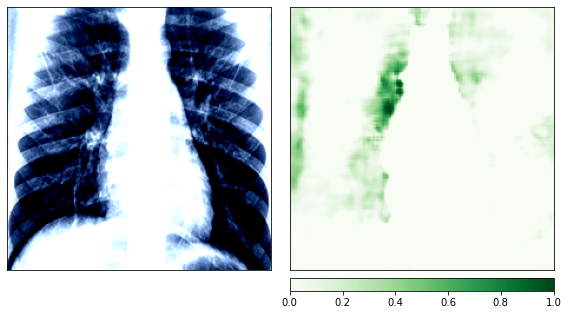

In [20]:
from captum.attr import visualization as viz

# Visualize the attribution output
_ = viz.visualize_image_attr_multiple(np.transpose(attr.squeeze().cpu().detach().numpy(), (1,2,0)),
                                        np.transpose(new_image.squeeze().cpu().detach().numpy(), (1,2,0)),
                                        ["original_image", "heat_map"],
                                        ["all", "positive"],
                                        show_colorbar=True,
                                        outlier_perc=2,
                                    )